In [1]:
import tensorflow as tf
import csv
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 Super, compute capability 7.5


In [3]:
records = []
from os import walk
for (dirpath, dirnames, filenames) in walk("records/"):
    for f in filenames:
        if "train" in f:
            records.append("records/{}".format(f))

print(records)

['records/train10-2071.tfrec', 'records/train12-2071.tfrec', 'records/train11-2071.tfrec', 'records/train06-2071.tfrec', 'records/train03-2071.tfrec', 'records/train02-2071.tfrec', 'records/train05-2071.tfrec', 'records/train13-2071.tfrec', 'records/train01-2071.tfrec', 'records/train15-2061.tfrec', 'records/train14-2071.tfrec', 'records/train07-2071.tfrec', 'records/train00-2071.tfrec', 'records/train08-2071.tfrec', 'records/train04-2071.tfrec', 'records/train09-2071.tfrec']


In [4]:
dataset = tf.data.TFRecordDataset(filenames = records)

In [5]:
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_name': tf.io.FixedLenFeature([], tf.string),
    'target': tf.io.FixedLenFeature([], tf.int64),
}

In [6]:
IMG_SIZE = 128

@tf.function
def toPairs(inp):
    example = tf.io.parse_single_example(inp, feature_description)
    img = tf.io.decode_image(example['image'], expand_animations = False, channels=3)
    img = tf.cast(img, tf.float32)
    img = (img/127.5) - 1
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    
    label = example['target']

    return img, label

In [7]:
alldata = dataset.map(toPairs)

In [8]:
total = 0
for i in iter(alldata):
    total += 1
print("{} images in total.".format(total))

33126 images in total.


In [9]:
train = 0.66
val = 0.33

train_data = alldata.take(int(total*train))
leftover = alldata.skip(int(total*train))
val_data = leftover.take(int(total*val))

In [10]:
BATCH_SIZE = 32
train_batches = train_data.batch(BATCH_SIZE)
val_batches = val_data.batch(BATCH_SIZE)

In [11]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

Second baseline - Transfer learning from inception

In [12]:
img_in = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

features = base_model(img_in)
features = tf.keras.layers.GlobalAveragePooling2D()(features)

predictor = tf.keras.layers.Dense(1, activation="sigmoid")(features)

model = tf.keras.Model(inputs=[img_in], outputs=predictor)

Precision - 
How many of the melanoma that we said are bad were actually bad?
Recall -
How many of the bad melanoma did we catch?

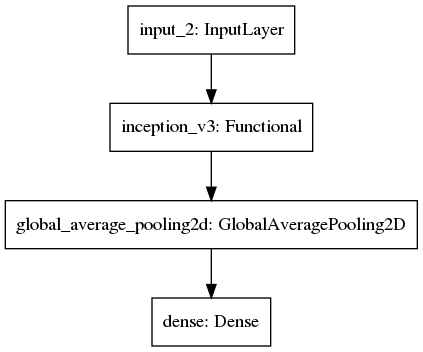

In [13]:
tf.keras.utils.plot_model(model)

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
          loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
          metrics=['Precision', 'Recall'])

In [ ]:
hist = model.fit(train_batches, validation_data=val_batches, epochs=18)

Epoch 1/18
684/684 [==============================] - 431s 631ms/step - loss: 0.1116 - precision: 0.0127 - recall: 0.0025 - val_loss: 0.0911 - val_precision: 0.1081 - val_recall: 0.0217
Epoch 2/18
684/684 [==============================] - ETA: 0s - loss: 0.0900 - precision: 0.1667 - recall: 0.0178